In this notebook we analyze and plot the results from predicting affect changes

In [19]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pylab as plt
import seaborn as sns

from nilearn.masking import unmask
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from joblib import Memory, dump
from tempfile import mkdtemp
from my_sklearn_tools.model_selection import StratifiedKFoldReg
from sklearn.linear_model._coordinate_descent import _alpha_grid

In [2]:
Y_df = pd.read_csv("../data/target_data.csv")
X = np.load("../data/input_data.npz")

tmpfolder = mkdtemp()
memory = Memory(location=tmpfolder, verbose=0)

pip = make_pipeline(VarianceThreshold(),
                    PCA(), 
                    Lasso(max_iter=1e6), 
                    memory=memory)
cv = StratifiedKFoldReg(n_splits=5, random_state=0, shuffle=True)
n_alphas=1000

mask_img = "../data/reslicedER_grey25grey25.nii"

In [24]:
def compute_ci(y_pred, y_true, n_boots=1000, alpha=0.05, random_state=None):
    n_obs = len(y_pred)
    idxs = np.arange(n_obs)
    
    np.random.seed(random_state)
    r_boots, r2_boots, mae_boots = [], [], []
    for ii in range(n_boots):
        idxs_boot = np.random.choice(idxs, n_obs)
        y_pred_boot = y_pred[idxs_boot]
        y_true_boot = y_true[idxs_boot]
        
        r = np.corrcoef(y_true_boot, y_pred_boot)[0,1]
        r2 = r2_score(y_true_boot, y_pred_boot)
        mae = mean_absolute_error(y_true_boot, y_pred_boot)
        
        r_boots.append(r)
        r2_boots.append(r2)
        mae_boots.append(mae)
    
    res_dict = dict()
    
    res_dict['r'] = np.quantile(r_boots, q=[alpha/2, 1-alpha/2])
    res_dict['r2'] = np.quantile(r2_boots, q=[alpha/2, 1-alpha/2])
    res_dict['mae'] = np.quantile(mae_boots, q=[alpha/2, 1-alpha/2])
    
    return res_dict

In [4]:
def compute_phenotypes(grid, X, mask_img):
    """
    Function to compute the phenotype maps
    
    """
    from nilearn.masking import unmask
    
    V = grid.best_estimator_.named_steps['pca'].components_ # PCA transformation
    beta =  grid.best_estimator_.named_steps['lasso'].coef_ # Coefficients in the PC space
    insert_voxels = grid.best_estimator_.named_steps['variancethreshold'].inverse_transform
    filter_voxels = grid.best_estimator_.named_steps['variancethreshold'].transform
    
    phenotypes_dict = dict()
    
    w = V.T @ beta
    
    w_dec = np.squeeze(insert_voxels(w[None, :]))
    w_dec_img = unmask(w_dec, mask_img)
    
    phenotypes_dict['w_dec'] = w_dec
    phenotypes_dict['w_dec_img'] = w_dec_img
    
    X_vt = filter_voxels(X)
    w_enc = X_vt.T @ (X_vt @ w)
    w_enc = np.squeeze(insert_voxels(w_enc[None,:]))
    w_enc_img = unmask(w_enc, mask_img)
    
    phenotypes_dict['w_enc'] = w_enc
    phenotypes_dict['w_enc_img'] = w_enc_img
    
    return phenotypes_dict

# CASE 1: Look Negative vs Look Neutral -> chg_LNeg_LNur 

In [5]:
# Load data
X_1 = X['look_neg_look_neut']
y_1 = Y_df.loc[:, "chg_LNeg_LNur"].to_numpy()

y_preds_1_df = pd.read_csv("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/y_preds.csv")

In [56]:
from scipy.stats import pearsonr
pearsonr(y_preds_1_df.y_pred, y_preds_1_df.y_true)

(0.14303130051230872, 0.08611558541530398)

In [50]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import permutation_test_score

pip = make_pipeline(VarianceThreshold(),
                    PCA(), 
                    Lasso(max_iter=1e6))
score, perm_scores, pvalue = permutation_test_score(pip, 
                                                    X_1, 
                                                    y_1, 
                                                    scoring="r2", 
                                                    cv=5, 
                                                    n_jobs=-1, 
                                                    random_state=0, 
                                                    verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.6min finished


In [7]:
# Fit model to find how MSE changes with lambda
alphas = _alpha_grid(PCA().fit_transform(VarianceThreshold().fit_transform(X_1)), y_1, n_alphas=n_alphas)

grid_1 = GridSearchCV(pip, 
                    param_grid={'lasso__alpha': alphas}, 
                    cv=cv, 
                    n_jobs=-1, 
                    scoring="neg_mean_squared_error", verbose=1)

grid_1.fit(X_1, y_1)
memory.clear(warn=False)

# Compute and save phenotypes
phenotypes_case_1 = compute_phenotypes(grid = grid_1, X = X_1, mask_img = mask_img)
# np.save("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/decoding_weights.npy", 
#         phenotypes_case_1['w_dec'])
# np.save("../results/prediction/chg_LNeg_LNur/look_neg_look_neut/encoding_weights.npy", 
#         phenotypes_case_1['w_enc'])

# phenotypes_case_1['w_dec_img'].to_filename("../images/look_neg_look_neut_chg_lneg_lneut_weights_decoding.nii.gz")
# phenotypes_case_1['w_enc_img'].to_filename("../images/look_neg_look_neut_chg_lneg_lneut_weights_encoding.nii.gz")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  6.2min finished


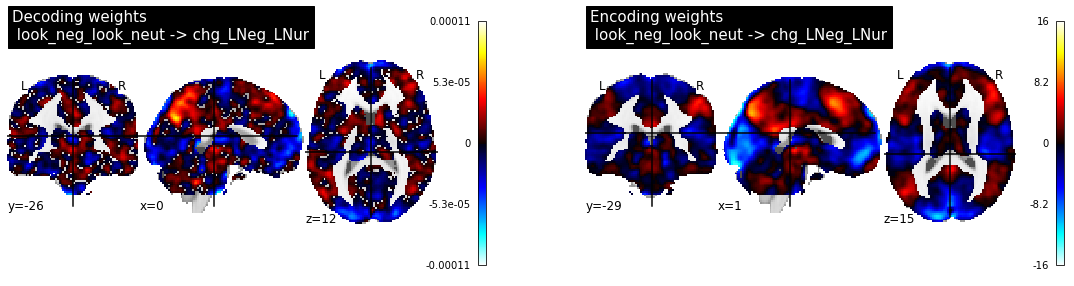

In [59]:
fig, axs = plt.subplots(ncols = 2, figsize=(19, 5))
plotting.plot_stat_map(phenotypes_case_1['w_dec_img'], title = "Decoding weights \n look_neg_look_neut -> chg_LNeg_LNur", axes = axs[0])
plotting.plot_stat_map(phenotypes_case_1['w_enc_img'], title = "Encoding weights \n look_neg_look_neut -> chg_LNeg_LNur", axes = axs[1])

In [34]:
# Statistics
res_ci = compute_ci(y_pred=y_preds_1_df.y_pred, y_true=y_preds_1_df.y_true, n_boots=1000, random_state=0)

print("R2 = %.3f [%.3f, %.3f]" % (r2_score(y_preds_1_df.y_true, y_preds_1_df.y_pred), 
                                  res_ci['r2'][0],
                                  res_ci['r2'][1]))

print("r = %.3f [%.3f, %.3f]" % (np.corrcoef(y_preds_1_df.y_true, y_preds_1_df.y_pred)[0,1], 
                                  res_ci['r'][0],
                                  res_ci['r'][1])
     )

print("MAE = %.3f [%.3f, %.3f]" % (mean_absolute_error(y_preds_1_df.y_true, y_preds_1_df.y_pred), 
                                  res_ci['mae'][0],
                                  res_ci['mae'][1]))

print("optimal lambda %f" % grid_1.best_params_['lasso__alpha'])
print("number of components selected = %d" % sum(grid_1.best_estimator_.named_steps['lasso'].coef_!=0))

R2 = 0.015 [-0.064, 0.075]
r = 0.143 [-0.015, 0.295]
MAE = 0.520 [0.454, 0.582]
optimal lambda 1.391426
number of components selected = 8


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


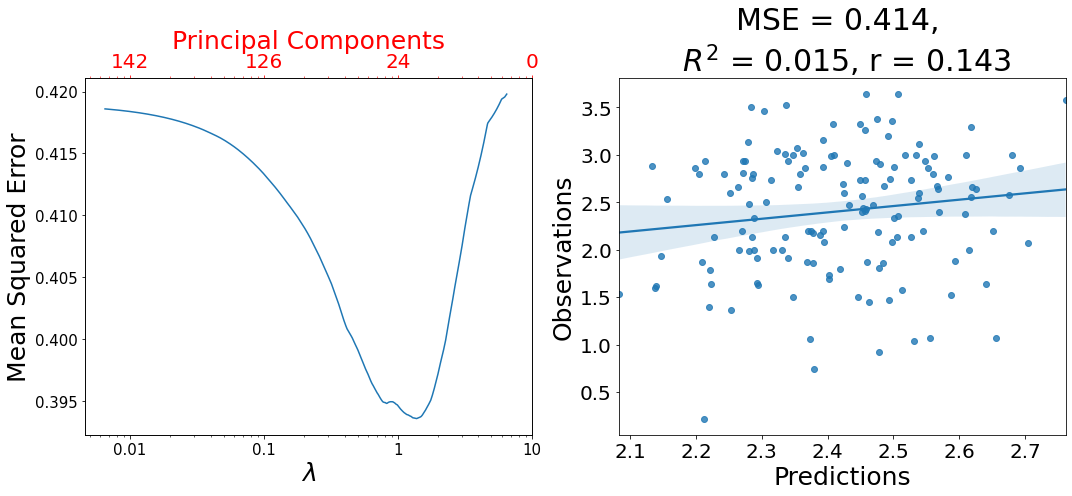

In [7]:
components_selected = []
for alpha in tqdm([0.01, 0.1, 1, 10]):
    pip.set_params(**{'lasso__alpha':alpha})
    pip.fit(X_1, y_1)
    components_selected.append(sum(pip.named_steps['lasso'].coef_!=0))

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].plot(alphas, -grid_1.cv_results_['mean_test_score'])
ax[0].set_xscale("log")
ax[0].set_xticks([0.01, 0.1, 1, 10])
ax[0].set_xticklabels(["0.01", "0.1", "1", "10"])
ax[0].set_xlabel(r'$\lambda$', size=25)
ax[0].set_ylabel("Mean Squared Error", size=25)
ax[0].tick_params(labelsize=15)
ax2 = ax[0].twiny()
ax2.plot(alphas, -grid_1.cv_results_['mean_test_score'], alpha=0)
ax2.set_xscale("log")
ax2.set_xticks([0.01, 0.1, 1, 10])
ax2.set_xticklabels(components_selected)
ax2.set_xlabel("Principal Components", size=25, color="red")
ax2.tick_params(axis='x', labelcolor="red", which="both", labelsize=20, color="red")

r = np.corrcoef(y_preds_1_df.loc[:,"y_true"],y_preds_1_df.loc[:,"y_pred"])[0,1]
r2 = r2_score(y_preds_1_df.loc[:,"y_true"],y_preds_1_df.loc[:,"y_pred"])
mse = mean_squared_error(y_preds_1_df.loc[:,"y_true"],y_preds_1_df.loc[:,"y_pred"])
sns.regplot(x="y_pred", y="y_true", data=y_preds_1_df, ax=ax[1], x_ci=None, n_boot=10000, seed=0)
ax[1].set_title("MAE = %.3f, \n $R^2$ = %.3f, r = %.3f"% (mse, r2, r), size=30)
ax[1].set_ylabel("Observations", size=25)
ax[1].set_xlabel("Predictions", size=25)
ax[1].tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("../plots/Figure_chg_lneg_lneutr.png", dpi=300)
plt.savefig("../plots/Figure_chg_lneg_lneutr.svg", dpi=300)
plt.savefig("../plots/Figure_chg_lneg_lneutr.pdf", dpi=300)
pass

# CASE 2: Regulate Negative vs Look Negative -> chg_RNeg_LNeg 

In [28]:
# Load data
X_2 = X['reg_neg_look_neg']
y_2 = Y_df.loc[:, "chg_RNeg_LNeg"].to_numpy()

y_preds_2_df = pd.read_csv("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/y_preds.csv")

In [29]:
# Fit model to find how MSE changes with lambda
alphas = _alpha_grid(PCA().fit_transform(VarianceThreshold().fit_transform(X_2)), y_2, n_alphas=n_alphas)

grid_2 = GridSearchCV(pip, 
                      param_grid={'lasso__alpha': alphas}, 
                      cv = cv, 
                      n_jobs = -1, 
                      scoring="neg_mean_squared_error", 
                      verbose=1)

grid_2.fit(X_2, y_2)
w_2 = compute_phenotype(grid_2)
memory.clear(warn=False)

# Compute and save phenotypes
phenotypes_case_2 = compute_phenotypes(grid = grid_2, X = X_2, mask_img = mask_img)
#np.save("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/decoding_weights.npy", 
 #       phenotypes_case_2['w_dec'])
# np.save("../results/prediction/chg_RNeg_LNeg/reg_neg_look_neg/encoding_weights.npy", 
#         phenotypes_case_2['w_enc'])

# phenotypes_case_2['w_dec_img'].to_filename("../images/reg_neg_look_neg_chg_rneg_lneg_weights_decoding.nii.gz")
# phenotypes_case_2['w_enc_img'].to_filename("../images/reg_neg_look_neg_chg_rneg_lneg_weights_encoding.nii.gz")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  6.3min finished


NameError: name 'compute_phenotype' is not defined

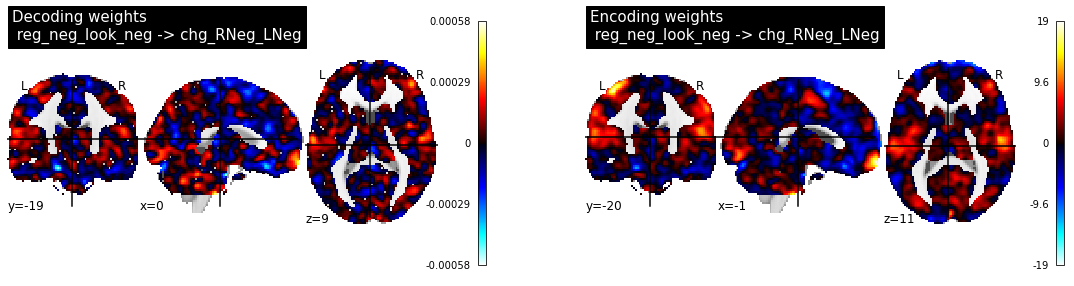

In [62]:
fig, axs = plt.subplots(ncols = 2, figsize=(19, 5))
plotting.plot_stat_map(phenotypes_case_2['w_dec_img'], title = "Decoding weights \n reg_neg_look_neg -> chg_RNeg_LNeg", axes = axs[0])
plotting.plot_stat_map(phenotypes_case_2['w_enc_img'], title = "Encoding weights \n reg_neg_look_neg -> chg_RNeg_LNeg", axes = axs[1])

In [31]:
# Statistics
res_ci = compute_ci(y_pred=y_preds_2_df.y_pred, y_true=y_preds_2_df.y_true, n_boots=1000, random_state=0)

print("R2 = %.3f [%.3f, %.3f]" % (r2_score(y_preds_2_df.y_true, y_preds_2_df.y_pred), 
                                  res_ci['r2'][0],
                                  res_ci['r2'][1]))

print("r = %.3f [%.3f, %.3f]" % (np.corrcoef(y_preds_2_df.y_true, y_preds_2_df.y_pred)[0,1], 
                                  res_ci['r'][0],
                                  res_ci['r'][1])
     )

print("MAE = %.3f [%.3f, %.3f]" % (mean_absolute_error(y_preds_2_df.y_true, y_preds_2_df.y_pred), 
                                  res_ci['mae'][0],
                                  res_ci['mae'][1]))

print("optimal lambda %f" % grid_2.best_params_['lasso__alpha'])
print("number of components selected = %d" % sum(grid_2.best_estimator_.named_steps['lasso'].coef_!=0))

R2 = 0.209 [0.073, 0.312]
r = 0.457 [0.307, 0.584]
MAE = 0.418 [0.367, 0.468]
optimal lambda 0.023291
number of components selected = 137


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


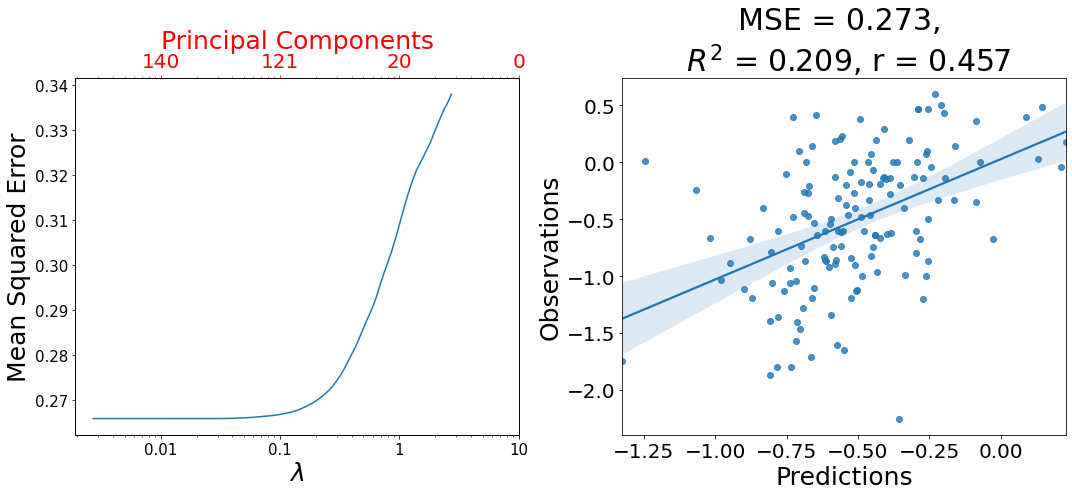

In [32]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
components_selected = []
for alpha in tqdm([0.01, 0.1, 1, 10]):
    pip.set_params(**{'lasso__alpha':alpha})
    pip.fit(X_2, y_2)
    components_selected.append(sum(pip.named_steps['lasso'].coef_!=0))

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].plot(alphas, -grid_2.cv_results_['mean_test_score'])
ax[0].set_xscale("log")
ax[0].set_xticks([0.01, 0.1, 1, 10])
ax[0].set_xticklabels(["0.01", "0.1", "1", "10"])
ax[0].set_xlabel(r'$\lambda$', size=25)
ax[0].set_ylabel("Mean Squared Error", size=25)
ax[0].tick_params(labelsize=15)
ax2 = ax[0].twiny()
ax2.plot(alphas, -grid_2.cv_results_['mean_test_score'], alpha=0)
ax2.set_xscale("log")
ax2.set_xticks([0.01, 0.1, 1, 10])
ax2.set_xticklabels(components_selected)
ax2.set_xlabel("Principal Components", size=25, color="red")
ax2.tick_params(axis='x', labelcolor="red", which="both", labelsize=20, color="red")

r = np.corrcoef(y_preds_2_df.loc[:,"y_true"], y_preds_2_df.loc[:,"y_pred"])[0,1]
r2 = r2_score(y_preds_2_df.loc[:,"y_true"], y_preds_2_df.loc[:,"y_pred"])
mse = mean_squared_error(y_preds_2_df.loc[:,"y_true"],y_preds_2_df.loc[:,"y_pred"])
sns.regplot(x="y_pred", y="y_true", data=y_preds_2_df, ax=ax[1], x_ci=None, n_boot=10000, seed=0)
ax[1].set_title("MSE = %.3f, \n $R^2$ = %.3f, r = %.3f"% (mse, r2, r), size=30)
ax[1].set_ylabel("Observations", size=25)
ax[1].set_xlabel("Predictions", size=25)
ax[1].tick_params(labelsize=20)

plt.tight_layout()
#plt.savefig("../plots/Figure_chg_rneg_lnegr.png", dpi=300)
#plt.savefig("../plots/Figure_chg_rneg_lnegr.svg", dpi=300)
#plt.savefig("../plots/Figure_chg_rneg_lnegr.pdf", dpi=300)
pass